### 推荐系统

本任务中实现一种称为协同过滤的特定推荐系统算法，并将其应用于电影评分的数据集。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('./datasets/ex8_movies.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
# Y是不同观众给不同电影的分数(0是没打分)
# R中是不同观众给不同电影有无打分(0是没打1是打过)
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [8]:
# 平均排序Y来评估电影的平均评级
# np.where()[0]表示按行索引
Y[1, np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

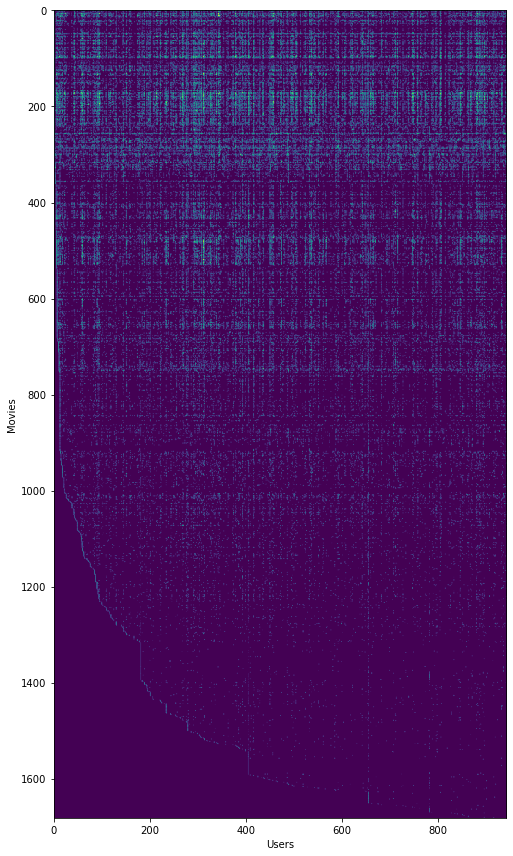

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

In [10]:
def serialize(X, theta):
    """序列化两个矩阵
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))

def deserialize(param, n_movie, n_user, n_features):
    """逆序列化"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), param[n_movie * n_features:].reshape(n_user, n_features)

# 计算代价函数
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2

In [13]:
# 评测预训练参数
params_data = loadmat('./datasets/ex8_movieParams.mat')
X = params_data['X']
theta = params_data['Theta']
X.shape, theta.shape

((1682, 10), (943, 10))

In [14]:
#小数据
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)

cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [15]:
param = serialize(X, theta)  # total real params

cost(serialize(X, theta), Y, R, 10)  # this is real total cost

27918.64012454421

In [16]:
# 计算梯度下降
def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)    

In [17]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),n_movie, n_user, 10)
X_grad, theta_grad

(array([[-6.26184144,  2.45936046, -6.87560329, ..., -4.81611896,
          3.84341521, -1.88786696],
        [-3.80931446,  1.80494255, -2.63877955, ..., -3.55580057,
          2.1709485 ,  2.65129032],
        [-3.13090116,  2.54853961,  0.23884578, ..., -4.18778519,
          3.10538294,  5.47323609],
        ...,
        [-1.04774171,  0.99220776, -0.48920899, ..., -0.75342146,
          0.32607323, -0.89053637],
        [-0.7842118 ,  0.76136861, -1.25614442, ..., -1.05047808,
          1.63905435, -0.14891962],
        [-0.38792295,  1.06425941, -0.34347065, ..., -2.04912884,
          1.37598855,  0.19551671]]),
 array([[-1.54728877,  9.0812347 , -0.6421836 , ..., -3.92035321,
          5.66418748,  1.16465605],
        [-2.58829914,  2.52342335, -1.52402705, ..., -5.46793491,
          5.82479897,  1.8849854 ],
        [ 2.14588899,  2.00889578, -4.32190712, ..., -6.83365682,
          1.78952063,  0.82886788],
        ...,
        [-4.59816821,  3.63958389, -2.52909095, ..., -

In [18]:
# 添加正则化的代价和梯度函数
def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term

In [19]:
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

In [20]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

本任务中我们创建自己的电影评分，以便可以使用该模型来生成个性化的推荐。为我们提供一个连接电影索引到其标题的文件。接着我们将文件加载到字典中。

In [23]:
movie_list = []
f = open('./datasets/movie_ids.txt',encoding= 'UTF-8')

for line in f:
    # strip()表示删除掉数据中的换行符，split（‘ ’）则是数据中遇到‘ ’ 就隔开
    #  print(tokens):['1', 'Toy', 'Story', '(1995)']     
    tokens = line.strip().split(' ')
    movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

In [24]:
movie_list[0]

'Toy Story (1995)'

In [25]:
# 初始化评分
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

ratings.shape

(1682, 1)

In [26]:
# 将自己的评级向量添加到现有数据集中以包含在模型中
Y = data['Y']
Y = np.append(ratings,Y, axis=1)  # now I become user 0
print(Y.shape)

(1682, 944)


In [27]:
R = data['R']
R = np.append(ratings != 0, R, axis=1)
R.shape

(1682, 944)

In [28]:
# 定义变量并进行归一化
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
theta = np.random.random(size=(users, features))
params = serialize(X, theta)

X.shape, theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [29]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

In [30]:
# 训练模型
from scipy.optimize import minimize

fmin = minimize(fun=regularized_cost, x0=params, args=(Y_norm, R, features, learning_rate), 
                method='TNC', jac=regularized_gradient)
fmin

     fun: 69380.70267947094
     jac: array([-6.23970344e-06, -5.54050320e-06, -6.46871884e-06, ...,
       -2.01097391e-06,  7.92725556e-07, -1.65205456e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1192
     nit: 44
  status: 1
 success: True
       x: array([ 0.87259634,  0.85955285,  0.41526116, ...,  1.35247284,
       -0.24449656,  0.17635136])

In [33]:
fmin.x.shape

(26260,)

In [34]:
X_trained, theta_trained = deserialize(fmin.x, movies, users, features)
X_trained.shape, theta_trained.shape

((1682, 10), (944, 10))

In [35]:
# 使用训练出的数据给出推荐电影
# 所有用户的电影分数矩阵
prediction = X_trained @ theta_trained.T
# 最后添加的用户的预测分数
my_preds = prediction[:, 0] + Y.mean()
# 得到my_preds的索引1~1682,并根据my_preds的大小，将最小值的索引排前面。[::-1]翻转，使之从大到小排列。
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [36]:
# top ten idx
my_preds[idx][:10]

array([4.28262545, 4.11498719, 3.98044845, 3.90580356, 3.88817789,
       3.87460969, 3.87178693, 3.86527055, 3.76237571, 3.75394229])

In [37]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Raiders of the Lost Ark (1981)
Good Will Hunting (1997)
Shawshank Redemption, The (1994)
Braveheart (1995)
Return of the Jedi (1983)
Empire Strikes Back, The (1980)
Terminator 2: Judgment Day (1991)
As Good As It Gets (1997)
